## Figure 2 cis pc-eQTLs mapped on principal components (PCs) of gene expression within clusters explain shared components of variation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns 
import upsetplot as up
from ast import literal_eval
from tqdm.auto import tqdm 
tqdm.pandas()
from sklearn.decomposition import PCA
from scipy.stats import linregress
from matplotlib.patches import Ellipse, Circle
from matplotlib.patheffects import withStroke


# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000


# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *
from annotate_null_clusters import get_null_pcs_annotated



tissue_ids = load_tissue_ids(config)

pc_pal = {'first':sns.color_palette('dark:#c4553aff_r',4)[1], 
          'middle':sns.color_palette('light:#c4553aff_r',3)[0], 
          'last':sns.color_palette('light:#c4553aff_r',3)[1]}

# colors
gtex_tissue_dict = {
    "Adipose_Subcutaneous": "#FFA54F",
    "Adipose_Visceral_Omentum": "#EE9A00",
    "Artery_Tibial": "#FF0000",
    "Cells_Cultured_fibroblasts": "#9AC0CD",
    "Esophagus_Mucosa": "#8B7355",
    "Esophagus_Muscularis": "#CDAA7D",
    "Lung": "#9ACD32",
    "Muscle_Skeletal": "#7A67EE",
    "Nerve_Tibial": "#FFD700",
    "Skin_Not_Sun_Exposed_Suprapubic": "#3A5FCD",
    "Skin_Sun_Exposed_Lower_leg": "#1E90FF",
    "Thyroid": "#008B45",
    "Whole_Blood": "#FF00FF"
}

gtex_tissue_abbrev = ['ADPSBQ',
                      'ADPVSC',
                      'ARTTBL',
                      'FIBRBLS',
                      'ESPMCS',
                      'ESPMSL',
                      'LUNG',
                      'MSCLSK',
                      'NERVET',
                      'SKINNS',
                      'SKINS',
                      'THYROID',
                      'WHLBLD']

gtex_tissue_pal = sns.color_palette(list(gtex_tissue_dict.values()))
gtex_tissue_pal_df = pd.DataFrame(pd.Series(gtex_tissue_dict), columns=['hex']).reset_index(names=['tissue_id'])
gtex_tissue_pal

[(1.0, 0.6470588235294118, 0.30980392156862746),
 (0.9333333333333333, 0.6039215686274509, 0.0),
 (1.0, 0.0, 0.0),
 (0.6039215686274509, 0.7529411764705882, 0.803921568627451),
 (0.5450980392156862, 0.45098039215686275, 0.3333333333333333),
 (0.803921568627451, 0.6666666666666666, 0.49019607843137253),
 (0.6039215686274509, 0.803921568627451, 0.19607843137254902),
 (0.47843137254901963, 0.403921568627451, 0.9333333333333333),
 (1.0, 0.8431372549019608, 0.0),
 (0.22745098039215686, 0.37254901960784315, 0.803921568627451),
 (0.11764705882352941, 0.5647058823529412, 1.0),
 (0.0, 0.5450980392156862, 0.27058823529411763),
 (1.0, 0.0, 1.0)]

In [2]:
gtex_tissue_abbrev = ['ADPSBQ',
                      'ADPVSC',
                      'ARTTBL',
                      'cells',
                      'ESPMCS',
                      'ESPMSL',
                      'LUNG',
                      'MSCLSK',
                      'NERVET',
                      'SKINNS',
                      'SKINS',
                      'THYROID',
                      'WHLBLD']

### a) var explained by pcs
if uncorrelated, PC1 explained varience will sum to 1. anything over that is shared variance. Compare to simulated uncorrelated data and to genome pairs.

In [ ]:
# load in the pcs
pc_annotated = load_across_tissues(config, load_pc_annotated)

# remove clusters with high cross map
clusters_annotated = load_across_tissues(config, load_clusters_annotated)
cross_map_ids = clusters_annotated[clusters_annotated['has_cross_map']]['cluster_id']
clusters_annotated = remove_cross_map(clusters_annotated, cross_map_ids)
pc_annotated = remove_cross_map(pc_annotated, cross_map_ids)


In [ ]:
# make a background distribuiton
def get_simulated_pc_var(corr_part, num_samples, num_repeats=100, num_genes=2):
    pc_var = []
    for i in tqdm(range(num_repeats), total=num_repeats):
        gene_pc_var = []
        corr = np.random.normal(0, 1, num_samples)
        Xs = []
        for j in range(num_genes):
            Xs.append((1-corr_part) * np.random.normal(0, 1, num_samples) + corr_part * corr)

        # fit PCA
        pca = PCA(n_components=num_genes).fit(np.column_stack(Xs))
        X_transform = pca.transform(np.column_stack(Xs))

        # var expalined by PCs
        for pc_idx in range(num_genes):
            pc_var_cluster = []
            for gene_idx in range(num_genes):
                slope, intercept, r_value, p_value, std_err = linregress(X_transform[:,pc_idx], Xs[gene_idx])
                pc_var_cluster.append(r_value**2)
            gene_pc_var.append(pc_var_cluster)
        pc_var.append(gene_pc_var)
    pc_var = np.asarray(pc_var)
    return pc_var


In [ ]:
# takes ~11m for one tissue
genome_var = get_null_pcs_annotated(config, 2, 'Cells_Cultured_fibroblasts')

 ... (more hidden) ...


Dropped 0 rows due to inf


100%|██████████████████████████████████| 26946/26946 [03:08<00:00, 142.84it/s]


In [ ]:
# varaince for clusters
cluster_summed_var = []
for n_genes, pc_annotated_group in pc_annotated[(pc_annotated['pc_id']==1)].groupby("cluster_size"):
    cluster_summed_var.append((pc_annotated_group.groupby(["cluster_id", "tissue_id", "pc_id", "cluster_size"])['egene_r2'].agg(sum) - 1)/(n_genes-1))
cluster_summed_var = np.asarray([item for sublist in cluster_summed_var for item in sublist])
# variance for genome background
genome_summed_var = (genome_var[genome_var['pc_id']==1].groupby(["cluster_id", "pc_id", "cluster_size"])['egene_r2'].agg(sum) - 1)

# varaince for simulated normals with no correlation
simulated_var = []
for (n_genes, size) in pd.DataFrame(clusters_annotated.groupby('N_genes').size()).iterrows():
        pc_var = get_simulated_pc_var(0, 500, num_repeats=size[0], num_genes=n_genes)
        simulated_var.append(((np.asarray(pc_var[:,0]).sum(axis=1))-1)/(n_genes-1))
flat_simulated_var = np.asarray([item for sublist in simulated_var for item in sublist])

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 27.33it/s]


/local/scratch/klawren/slrmtmp.47636521/ipykernel_39249/1191151114.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot({'Clusters':cluster_summed_var, 'Non-cluster pairs':genome_summed_var.values, 'Simulated':flat_simulated_var}, ax=ax, palette=['#c4553aff', 'grey', 'grey'], color='grey', fill=False, cut=0)
/local/scratch/klawren/slrmtmp.47636521/ipykernel_39249/1191151114.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Clusters', 'Non-cluster \npairs', 'Simulated \nuncorrelated'], rotation=-45)


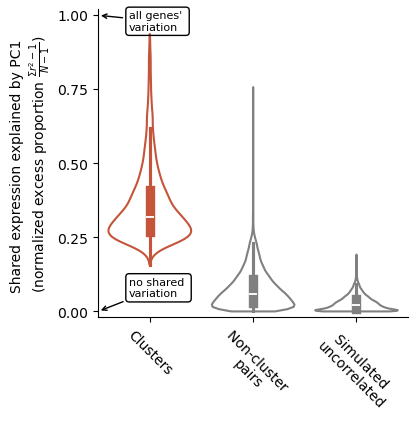

In [ ]:
# violin plot version
fig, ax = plt.subplots(figsize=(4,4))
sns.violinplot({'Clusters':cluster_summed_var, 'Non-cluster pairs':genome_summed_var.values, 'Simulated':flat_simulated_var}, ax=ax, palette=['#c4553aff', 'grey', 'grey'], color='grey', fill=False, cut=0)
ax.set_ylim((-.02,1.02))
ax.set_yticks([0, .25,.50, .75, 1])
ax.set_ylabel("Shared expression explained by PC1 \n(normalized excess proportion " r"$\frac{\Sigma r^2-1}{N-1}$)")
ax.spines[['right', 'top']].set_visible(False)

# Add annotations
ax.annotate("no shared \nvariation", xy=(-0.5, 0), xytext=(-.2, 0.05),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=8, color='black', ha='left',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.3'))

ax.annotate("all genes' \nvariation", xy=(-0.5, 1), xytext=(-0.2, .95),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=8, color='black', ha='left',
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.3'))

ax.set_xticklabels(['Clusters', 'Non-cluster \npairs', 'Simulated \nuncorrelated'], rotation=-45)
plt.show()

### b) fraciton of clusters with credible set

In [ ]:
# takes about 2.5 minutes
underlying_signals = load_across_tissues(config, load_signal_groups)
#underlying_signals = remove_cross_map(underlying_signals, config=config)

# only pcqtls, not eqtls
pc_underlying_signals = underlying_signals[underlying_signals['num_pc_coloc'] > 0]
# number of pcqtls signals per cluster
pcqtls_per_cluster = pc_underlying_signals.groupby(['tissue_id', 'cluster_id']).agg({'signal_id':'nunique'}).rename(columns={'signal_id':'unique_pcqtls'}).reset_index()
# add in clusters without any
pcqtls_per_cluster = pd.merge(clusters_annotated[['cluster_id', 'tissue_id']], pcqtls_per_cluster, how='left', on=['cluster_id', 'tissue_id'])
pcqtls_per_cluster['unique_pcqtls'].fillna(0, inplace=True)
pcqtls_per_cluster['unique_pcqtls_clip'] = pcqtls_per_cluster['unique_pcqtls'].clip(0,5)

# group by tissue 
pcqtls_per_cluster_dist = pcqtls_per_cluster.groupby(['tissue_id', 'unique_pcqtls_clip']).agg({'cluster_id':'nunique'}).reset_index()
pcqtls_per_cluster_dist['clusters_or_higher'] = pcqtls_per_cluster_dist.apply(
    lambda row: pcqtls_per_cluster_dist[
        (pcqtls_per_cluster_dist['tissue_id'] == row['tissue_id']) & 
        (pcqtls_per_cluster_dist['unique_pcqtls_clip'] >= row['unique_pcqtls_clip'])
    ]['cluster_id'].sum(),
    axis=1
)
# count the total per tissue to normalize
total_clusters_per_tissue = pcqtls_per_cluster.groupby(['tissue_id']).agg({'cluster_id':'nunique'}).rename(columns={'cluster_id':'total_clusters'}).reset_index()
pcqtls_per_cluster_dist = pcqtls_per_cluster_dist.merge(total_clusters_per_tissue, on='tissue_id')
pcqtls_per_cluster_dist['fraction_clusters'] = pcqtls_per_cluster_dist['clusters_or_higher']/pcqtls_per_cluster_dist['total_clusters']


NameError: name 'clusters_annotated' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(4, 5))

for num_loci in np.arange(1,6):
    subset = pcqtls_per_cluster_dist[pcqtls_per_cluster_dist['unique_pcqtls_clip'] == num_loci]
    sns.barplot(subset, y='tissue_id', x='fraction_clusters', ax=ax, 
        color=sns.color_palette("light:#B83A4B", 6)[num_loci])

# make the legend
labels = ['1', '2', '3', '4', '5+']
patches = [plt.Rectangle((0, 0), 1, 1, facecolor=sns.color_palette("light:#B83A4B", 6)[1:][i]) for i in range(len(labels))]
ax.legend(patches, labels, title='pcQTLs/cluster', loc='upper left', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# make the plot pretty
ax.spines[['top', 'left', 'right']].set_visible(False)
ax.set_xlabel('Proportion clusters')
ax.set_ylabel('')

# y axis tissue labels
ax.set_yticklabels('')

ax.set_xlim([0,1])
ax.set_xticks([0, .5, 1])


# Add colored circles next to the y-ticks
for i, label in enumerate(gtex_tissue_abbrev):
    # circle = Circle((-0.2, i), 0.3, color=gtex_tissue_pal[i], ec='black', linewidth=2.5, zorder=10)
    c = Ellipse((-0.07, i), .07, .7, clip_on=False, zorder=10, linewidth=0,
               edgecolor='none', facecolor=gtex_tissue_pal[i])
    ax.add_artist(c)
    ax.text(-0.13, i, label, verticalalignment='center', horizontalalignment='right')

plt.show()

NameError: name 'plt' is not defined

### c) number pcqlts per cluster as a function of cluster size

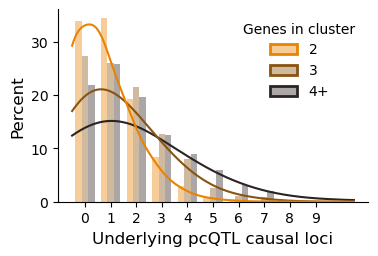

In [ ]:
pcqtls_per_cluster['num_genes'] = pcqtls_per_cluster['cluster_id'].str.split('_').apply(len).clip(0,4)

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.histplot(pcqtls_per_cluster, hue='num_genes', x='unique_pcqtls', common_norm=False, stat='percent', 
             bins=np.arange(0, 10), multiple='dodge', ax=ax, shrink=.75, palette=sns.color_palette("dark:#E98300_r", 3), kde=True, kde_kws={'bw_adjust':3}, alpha=.4, linewidth=0)


labels = ['2', '3', '4+']
palette = sns.color_palette("dark:#E98300_r", 3)
alpha_palette = [(color[0], color[1], color[2], 0.4) for color in palette]  # Adding alpha 0.5
patches = [plt.Rectangle((0, 0), 1, 1, edgecolor=palette[i], facecolor=alpha_palette[i], linewidth=2) for i in range(len(labels))]
ax.legend(patches, labels, title='Genes in cluster', loc='upper right', frameon=False)

# make the plot pretty
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Underlying pcQTL causal loci', fontsize=12)
ax.set_ylabel('Percent', fontsize=12)

ax.set_yticks([0,10,20,30])
xticks = np.arange(0,10) + .5
xtick_labels =  np.arange(0,10)
ax.set_xticks(xticks, xtick_labels)

plt.show()

### d) pcqtls effect size for top two genes

top gene effect size vs second largest gene effect size?

fraction of top gene effect size that is second largest gene effect size?


In [ ]:
# takes about 30 secs
susie_annotated = load_across_tissues(config, load_susie_annotated)

# Define a function that uses literal_eval with error handling
def safe_literal_eval(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return None  # or any other default value

susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].apply(safe_literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].apply(safe_literal_eval)
susie_annotated['egene_variance_list'] = susie_annotated['egene_variance_list'].apply(safe_literal_eval)
# expand out over all egenes for a given pcqtl
susie_annotated_egene_explode = susie_annotated.explode(['egene_variance_list', 'egene_id_list'])
# weight by pip
susie_annotated_egene_explode['pip_weighted_eqtl_variance'] = susie_annotated_egene_explode['egene_variance_list']*susie_annotated_egene_explode['pip']
# group by credible sets and egene
cs_grouped_eqtl_mapped = susie_annotated_egene_explode.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'egene_id_list']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'pip_weighted_eqtl_variance':sum}).reset_index()
# group over egenes in a credible set
cs_grouped_eqtl_mapped = cs_grouped_eqtl_mapped.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'egene_id_list':list,
                                                                                  'pip_weighted_eqtl_variance':list}).reset_index()

def get_largest_two(lst):
    if not lst:
        return None, None 
    sorted_slopes = sorted(lst, key=abs, reverse=True) 
    largest = sorted_slopes[0] if len(sorted_slopes) > 0 else None
    second_largest = sorted_slopes[1] if len(sorted_slopes) > 1 else None
    return largest, second_largest
cs_grouped_eqtl_mapped[['largest_eqtl_var', 'second_largest_eqtl_var']] = cs_grouped_eqtl_mapped['pip_weighted_eqtl_variance'].apply(get_largest_two).apply(pd.Series)
cs_grouped_eqtl_mapped['eqtl_var_fraction'] = cs_grouped_eqtl_mapped['second_largest_eqtl_var']/cs_grouped_eqtl_mapped['largest_eqtl_var']

# pull just the pcqtls
pcqtl_cs_grouped_eqtl_mapped = cs_grouped_eqtl_mapped[cs_grouped_eqtl_mapped['type']=='pcqtl']
annotate_pc_order(pcqtl_cs_grouped_eqtl_mapped)

# remove cross map
pcqtl_cs_grouped_eqtl_mapped = remove_cross_map(pcqtl_cs_grouped_eqtl_mapped, cross_map_ids)

/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc_df['pc_num'] = pc_df['phenotype_id'].str.split('_pc').str[-1].astype(int)
/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc_df['cluster_id'] = pc_df['phenotype_id'].str.split('_pc').str[0]
/home/klawren/oak/pcqtls/workflow/scripts/notebook_helper_functions.py:259: SettingWithCopyWarning: 
A value is trying to b

(3.1622776601683795e-05, 3.1622776601683795)

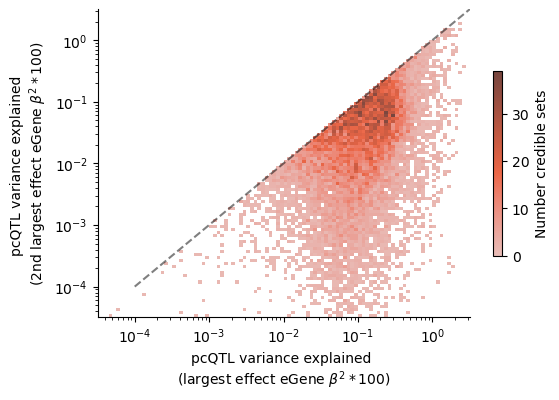

In [ ]:
# visualize the effect sizes on the top two genes in the cluster
fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(pcqtl_cs_grouped_eqtl_mapped, x='largest_eqtl_var', y='second_largest_eqtl_var',log_scale=(True, True), ax=ax, 
             color='#c4553aff', cbar=True, cbar_kws={'shrink':.6, 'label':'Number credible sets'}, bins=(np.arange(-4.5, .5, .05), np.arange(-4.5, .5, .05)))

ax.set_xlabel('pcQTL variance explained \n(largest effect eGene ' r'$\beta^2*100$)')
ax.set_ylabel('pcQTL variance explained \n(2nd largest effect eGene ' r'$\beta^2*100$)')

ax.spines[['top', 'right']].set_visible(False)
ax.plot([10e-5, 4], [10e-5, 4], '--', color='k', alpha=.5)

ax.set_ylim((10**(-4.5), 10**(.5)))
ax.set_xlim((10**(-4.5), 10**(.5)))


### fraction of all var explained by QTL in just 1 gene

Text(0, 0.5, 'Number credible sets')

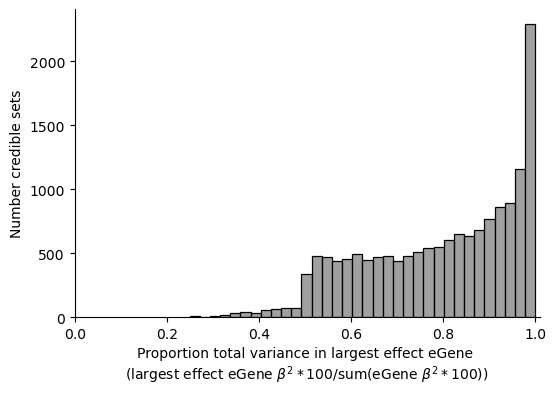

In [ ]:
pcqtl_cs_grouped_eqtl_mapped['total_of_varience'] = pcqtl_cs_grouped_eqtl_mapped['pip_weighted_eqtl_variance'].apply(sum)
pcqtl_cs_grouped_eqtl_mapped['frac_largest_eqtl_var'] = pcqtl_cs_grouped_eqtl_mapped['largest_eqtl_var'] / pcqtl_cs_grouped_eqtl_mapped['total_of_varience']

fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(pcqtl_cs_grouped_eqtl_mapped, x='frac_largest_eqtl_var', ax=ax, color='grey', ec='k')

ax.set_xlabel('Proportion total variance in largest effect eGene \n' r'(largest effect eGene $\beta^2*100$/sum(eGene $\beta^2*100$))')
ax.set_xlim([0,1.01])
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Number credible sets')


## Supplementary figures

### credible set sizes

In [ ]:
# load in data for all tissues 
pc_susie = load_across_tissues(config, load_pc_susie)
pc_susie = remove_cross_map(pc_susie, cross_map_ids)
credible_set_sizes = pc_susie.groupby(['tissue_id', 'cs_id']).agg({'variant_id':'nunique'})

fig, ax = plt.subplots(figsize=(4,2.5))
sns.histplot(credible_set_sizes, x='variant_id', bins=np.arange(0, 100), ax=ax, color='grey')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Variants in credible set', fontsize=12)
ax.set_ylabel('Credible sets', fontsize=12)
plt.show()

var from PC vs var from QTL

In [ ]:
# merge pc annotaitons in pcqtl annotaitons, on a per egene basis needs
pcqtl_cs_grouped_eqtl_mapped_pc_annot = pd.merge(left=pcqtl_cs_grouped_eqtl_mapped.explode(['egene_id_list', 'pip_weighted_eqtl_variance']), 
                                                right=pc_annotated, 
                                                left_on=['egene_id_list', 'phenotype_id', 'tissue_id'],
                                                right_on=['egene_id', 'pc_phenotype_id', 'tissue_id'], how='left')

pcqtl_cs_grouped_eqtl_mapped_pc_annot['pip_weighted_eqtl_variance'] = pcqtl_cs_grouped_eqtl_mapped_pc_annot['pip_weighted_eqtl_variance'].astype(float)
pcqtl_cs_grouped_eqtl_mapped_pc_annot['egene_r2'] = pcqtl_cs_grouped_eqtl_mapped_pc_annot['egene_r2'].astype(float) * 100


fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(pcqtl_cs_grouped_eqtl_mapped_pc_annot, x='egene_r2', y='pip_weighted_eqtl_variance', ci=False, scatter=False, lowess=False, ax=ax, color='k')
sns.histplot(pcqtl_cs_grouped_eqtl_mapped_pc_annot, x='egene_r2', y='pip_weighted_eqtl_variance', bins=(np.arange(0, 100, 1), np.arange(0, .5, .005)), ax=ax, color='#c4553aff')
#ax.set_ylim(.000001, .1)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Expression variance explained by PC', fontsize=12)
ax.set_ylabel('Expression variance explained by pcQTL', fontsize=12)
plt.show()

# merge pc annotaitons in pcqtl annotaitons, on a per egene basis needs
pcqtl_cs_grouped_eqtl_mapped_pc_annot = pd.merge(left=pcqtl_cs_grouped_eqtl_mapped.explode(['egene_id_list', 'pip_weighted_eqtl_variance']), 
                                                right=pc_annotated, 
                                                left_on=['egene_id_list', 'phenotype_id', 'tissue_id'],
                                                right_on=['egene_id', 'pc_phenotype_id', 'tissue_id'], how='left')

pcqtl_cs_grouped_eqtl_mapped_pc_annot['pip_weighted_eqtl_variance'] = pcqtl_cs_grouped_eqtl_mapped_pc_annot['pip_weighted_eqtl_variance'].astype(float)

fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(pcqtl_cs_grouped_eqtl_mapped_pc_annot, x='egene_r2', y='pip_weighted_eqtl_variance', ci=False, scatter=False, lowess=True, ax=ax, color='k')
sns.histplot(pcqtl_cs_grouped_eqtl_mapped_pc_annot, x='egene_r2', y='pip_weighted_eqtl_variance', bins=100, log_scale=(False, True), ax=ax, color='#c4553aff')
ax.set_ylim(.000001, 4)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Expression variance explained by PC', fontsize=12)
ax.set_ylabel('Expression variance explained by pcQTL', fontsize=12)
plt.show()

NameError: name 'pcqtl_cs_grouped_eqtl_mapped' is not defined

### distribution for top 2 genes PC variance

In [ ]:

# get the top two egene variances per pc
pc_annotated_largest = pc_annotated.groupby(["pc_phenotype_id", "tissue_id", "pc_id", "cluster_size"])['egene_r2'].apply(lambda x: x.nlargest(2).tolist()).reset_index()
pc_annotated_largest['egene_r2_1'] = pc_annotated_largest['egene_r2'].str[0] * 100
pc_annotated_largest['egene_r2_2'] = pc_annotated_largest['egene_r2'].str[1] * 100
# get fraction between two largest
pc_annotated_largest['frac_r2'] = pc_annotated_largest['egene_r2_2']/pc_annotated_largest['egene_r2_1']
# add pc order tags
pc_annotated_largest['phenotype_id'] = pc_annotated_largest['pc_phenotype_id']
annotate_pc_order(pc_annotated_largest)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(4,5))

sns.scatterplot(pc_annotated_largest, x='egene_r2_1', y='egene_r2_2', hue="pc_order", s=3, edgecolor=None, ax=ax1,
                palette=pc_pal)

# Set labels
ax1.set_xlabel('PC variance explained \n(1st largest egene)')
ax1.set_ylabel('PC variance explained \n(2nd largest egene)')

ax1.spines[['top', 'right']].set_visible(False)
ax1.set_xlim(0,100)
ax1.set_ylim(0,100)

# Show the plot
ax1.legend(title='PC type', frameon=False)
#sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

sns.histplot(pc_annotated_largest, x='frac_r2', hue='pc_order', bins=50, legend=False, ax=ax2,
             palette=pc_pal, common_norm=True, stat='percent', multiple='stack', fill=True)
ax2.spines[['top', 'right']].set_visible(False)
#ax2.set_yscale('log')
ax2.set_xlabel('(1st largest egene)/(2nd largest egene)')
fig.tight_layout()


### old distribution of qtl varainces

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(4,5))

pcqtl_cs_grouped_eqtl_mapped['largest_eqtl_var_clip'] = pcqtl_cs_grouped_eqtl_mapped['largest_eqtl_var'].clip(0,1)
pcqtl_cs_grouped_eqtl_mapped['second_largest_eqtl_var_clip'] = pcqtl_cs_grouped_eqtl_mapped['second_largest_eqtl_var'].clip(0,1)
sns.scatterplot(pcqtl_cs_grouped_eqtl_mapped, x='largest_eqtl_var_clip', y='second_largest_eqtl_var_clip', hue="pc_order", s=3, edgecolor=None, ax=ax1, alpha=.5,
                palette=pc_pal)

# Set labels
ax1.set_xlabel('pcQTL variance explained \n(1st largest egene)')
ax1.set_ylabel('pcQTL variance explained \n(2nd largest egene)')

ax1.spines[['top', 'right']].set_visible(False)
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)

# Show the plot
ax1.legend(title='PC type', frameon=False)
sns.histplot(pcqtl_cs_grouped_eqtl_mapped, x='eqtl_var_fraction', hue='pc_order', bins=50, legend=False, ax=ax2,
             palette=pc_pal, common_norm=False, stat='percent', multiple='stack', element='step', fill=False)
ax2.spines[['top', 'right']].set_visible(False)
#ax2.set_yscale('log')
ax2.set_xlabel('(1st largest egene)/(2nd largest egene)')
fig.tight_layout()


#### number of pcqtl loci per tissue

In [ ]:

# count the total per tissue to normalize
total_clusters_per_tissue = pcqtls_per_cluster.groupby(['tissue_id']).agg({'cluster_id':'nunique'}).rename(columns={'cluster_id':'total_clusters'}).reset_index()
pcqtls_per_cluster_dist = pcqtls_per_cluster_dist.merge(total_clusters_per_tissue, on='tissue_id')
pcqtls_per_cluster_dist['fraction_clusters'] = pcqtls_per_cluster_dist['clusters_or_higher']/pcqtls_per_cluster_dist['total_clusters']

fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(pcqtls_per_cluster_dist[pcqtls_per_cluster_dist['unique_pcqtls_clip'] > 0], y='tissue_id', hue='unique_pcqtls_clip', x='fraction_clusters', ax=ax, 
    palette=sns.color_palette("light:#B83A4B", 6)[1:])

# make the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [int(float(l)) for l in labels[:-1]]
new_labels.append('5+')
ax.legend(handles, new_labels, title='underlying pcQTL loci', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# make the plot pretty
ax.spines[['top', 'left', 'right']].set_visible(False)
ax.set_xlabel('Number clusters with pcQTL/number of tested clusters')
ax.set_ylabel('')

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlim([0,1])
ax.set_xticks([0, .5, 1])

plt.show()

MergeError: Passing 'suffixes' which cause duplicate columns {'total_clusters_x'} is not allowed.

### Supp: per cluster, how many pcs pass cutoff?

/local/scratch/klawren/slrmtmp.47327205/ipykernel_32057/599154815.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


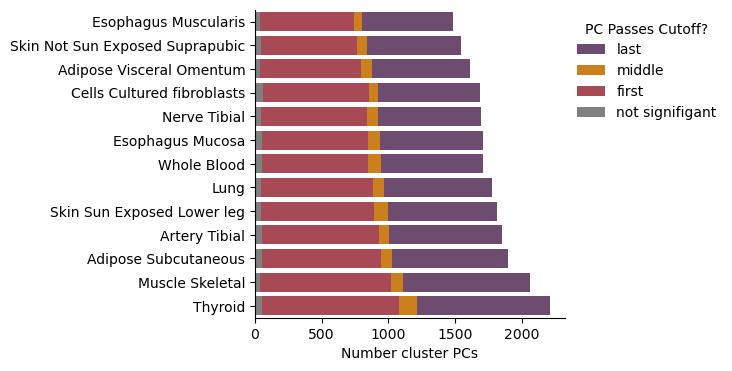

In [ ]:
# set the cutoff to 10%
pc_annotated_largest['pc_passes_cutoff'] = pc_annotated_largest['egene_r2_2'] > pc_cutoff
pc_annotated_largest.loc[~pc_annotated_largest['pc_passes_cutoff'],'pc_order']="didnt_pass"


# group by tissue and, count the number that pass and the total number
pc_passed_cutoff = pc_annotated_largest.groupby(['tissue_id', 'pc_order']).size().reset_index()

fig, ax = plt.subplots(figsize=(4,4))
tissue_order = pc_annotated_largest.groupby(['tissue_id']).size().sort_values().index.values

# start with the all pcs, colored for last
sns.barplot(pc_passed_cutoff, y='tissue_id', x=0, ax=ax, color='#734675', label='last', estimator=sum, errorbar=None, order=tissue_order)
# add in the middle and first pcs, colored for middle
sns.barplot(pc_passed_cutoff[pc_passed_cutoff['pc_order'].isin(['middle', 'first', 'didnt_pass'])], ax=ax, y='tissue_id', x=0, color='#E98300', label='middle', estimator=sum, errorbar=None)
# add in the first pcs, colored for first
sns.barplot(pc_passed_cutoff[pc_passed_cutoff['pc_order'].isin(['first', 'didnt_pass'])], ax=ax, y='tissue_id', x=0, color='#B83A4B', label='first', estimator=sum, errorbar=None)
# add in the didnt pass pcs, colored grey
sns.barplot(pc_passed_cutoff[pc_passed_cutoff['pc_order'].isin(['didnt_pass'])], ax=ax, y='tissue_id', x=0, color='grey', label="not signifigant", estimator=sum, errorbar=None)


# Create the legend in a separate location
ax.legend(title="PC Passes Cutoff?", loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Set labels
ax.set_xlabel('Number cluster PCs')
ax.set_ylabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

plt.show()


### supp pcqtls in removed pcs

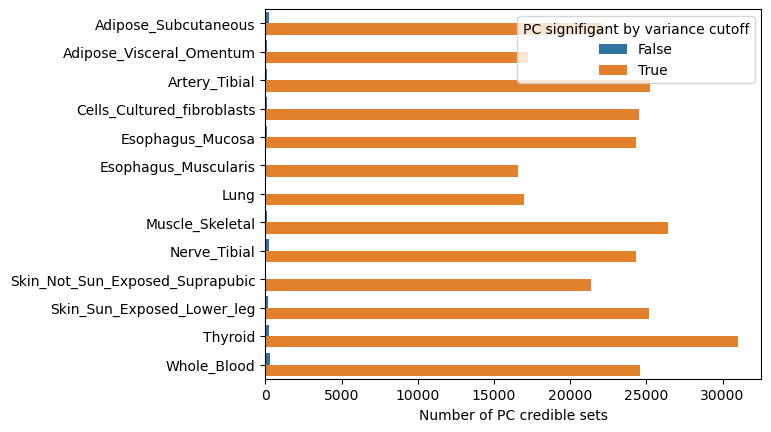

In [ ]:
# aside: confirm most pcqtl credible sets are in a pc that passes cutoffs
pc_susie['pc_passes_cutoff'] = pc_susie['phenotype_id'].isin(pc_annotated_largest[pc_annotated_largest['egene_r2_2'] > 10]['pc_phenotype_id'])

ax = sns.countplot(pc_susie, y='tissue_id', hue='pc_passes_cutoff')
ax.set_xlabel("Number of PC credible sets")
ax.set_ylabel("")
# Change legend title
leg = ax.get_legend()
leg.set_title('PC signifigant by variance cutoff')